In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Ensure project root is on path
PROJECT_ROOT = Path.cwd().resolve().parents[0]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from project_code.functions import *
from sklearn.metrics import log_loss
from scipy.stats import pearsonr, spearmanr

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
exports = Path("../exports")

def latest_timestamp(prefix="wp_model_", suffix=".joblib"):
    pat = re.compile(rf"^{re.escape(prefix)}(\d{{8}}_\d{{4}}){re.escape(suffix)}$")
    ts_list = []
    for p in exports.iterdir():
        m = pat.match(p.name)
        if m:
            ts_list.append(m.group(1))
    if not ts_list:
        raise FileNotFoundError(f"No files matching {prefix}YYYYMMDD_HHMM{suffix} in {exports.resolve()}")
    return sorted(ts_list)[-1]

ts = latest_timestamp(prefix="wp_model_", suffix=".joblib")
print("Loading timestamp:", ts)


Loading timestamp: 20260124_1049


In [4]:
# ---------- Variables ----------
test_season   = joblib.load(f"../exports/test_season_{ts}.joblib")
wp_features   = joblib.load(f"../exports/wp_features_{ts}.joblib")
wp_base_features   = joblib.load(f"../exports/wp_base_features_{ts}.joblib")
go_features   = joblib.load(f"../exports/go_features_{ts}.joblib")
fg_features   = joblib.load(f"../exports/fg_features_{ts}.joblib")
punt_features = joblib.load(f"../exports/punt_features_{ts}.joblib")
fg_features   = joblib.load(f"../exports/fg_features_{ts}.joblib")
go_folds = joblib.load(f"../exports/go_folds_{ts}.joblib")

# ---------- DataFrames ----------
raw_pbp = pd.read_parquet(f"../exports/raw_pbp{ts}.parquet")
pbp = pd.read_parquet(f"../exports/pbp{ts}.parquet")
pbp_fourth_train = pd.read_parquet(f"../exports/pbp_fourth_train_{ts}.parquet")
pbp_fourth_test  = pd.read_parquet(f"../exports/pbp_fourth_test_{ts}.parquet")

# ---------- Models ----------
wp_model   = joblib.load(f"../exports/wp_model_{ts}.joblib")
go_model   = joblib.load(f"../exports/go_model_{ts}.joblib")
fg_model   = joblib.load(f"../exports/fg_model_{ts}.joblib")
punt_model = joblib.load(f"../exports/punt_model_{ts}.joblib")

# Objects
X_scaler = joblib.load(f"../exports/X_scaler_{ts}.joblib")
y_scaler = joblib.load(f"../exports/y_scaler_{ts}.joblib")

In [33]:
state = {
  "yardline_100": 4,
  "down": 4,
  "ydstogo": 4,
  "game_seconds_remaining": 1250,
  "half_seconds_remaining": 1250,
  "score_differential": 0,
  "posteam_timeouts_remaining": 2,
  "defteam_timeouts_remaining": 2,
  "temp_F": 20,
  "wind_mph": 10,
  "possession_spread_line": -4.5,
  "total_line": 43.5
}

test_results, fourth_test_results = create_df_with_ewp(
    pd.DataFrame([state]),
    wp_model=wp_model,
    go_model=go_model,
    fg_model=fg_model,
    punt_model=punt_model,
    wp_features=wp_features,
    wp_base_features=wp_base_features,
    go_features=go_features,
    fg_features=fg_features,
    punt_features=punt_features,
    test=True
)


TOPLINE
----------------------------------------
wp_current                    : 0.6070
recommended_play              : field_goal
decision_margin               : 0.0043

EXPECTED WIN PROBABILITIES
----------------------------------------
go                            : 0.6115   (Δ: +0.0046)
field goal                    : 0.6158   (Δ: +0.0088)
punt                          : 0.5153   (Δ: -0.0917)

GO DETAILS
----------------------------------------
p_convert                     : 0.2895
wp_success                    : 0.7669
wp_fail                       : 0.5482

FG DETAILS
----------------------------------------
p_make_fg                     : 0.9794
wp_success                    : 0.6179
wp_fail                       : 0.5153

PUNT CONTEXT
----------------------------------------
predicted net punt yds        : 21.0129



Brier score:  0.16708
Reliability:  0.00030
Resolution:   0.08236
Uncertainty:  0.24914


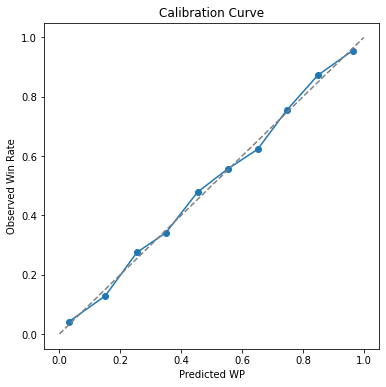

In [6]:
# Calibration + Brier + Murphy decomposition
y = pbp_fourth_test["win_actual"].astype(float).to_numpy()
p = pbp_fourth_test["wp_pred"].astype(float).to_numpy()

# Bin predicted probabilities
bins = np.linspace(0, 1, 11)  # 10 equal-width bins
wp_bin = pd.cut(pbp_fourth_test["wp_pred"], bins=bins, include_lowest=True)

# Aggregate by bin
cal_table = (
    pbp_fourth_test
    .groupby(wp_bin, observed=False)
    .agg(
        wp_pred_mean=("wp_pred", "mean"),
        win_rate=("win_actual", "mean"),
        count=("win_actual", "count"),
    )
    .reset_index()
)

N = len(pbp_fourth_test)
p_bar = cal_table["wp_pred_mean"].to_numpy(dtype=float)
o_bar = cal_table["win_rate"].to_numpy(dtype=float)
n_k  = cal_table["count"].to_numpy(dtype=float)

o = y.mean()

reliability = np.sum((n_k / N) * (p_bar - o_bar) ** 2)
resolution  = np.sum((n_k / N) * (o_bar - o) ** 2)
uncertainty = o * (1.0 - o)

brier = reliability - resolution + uncertainty

print(f"Brier score:  {brier:.5f}")
print(f"Reliability:  {reliability:.5f}")
print(f"Resolution:   {resolution:.5f}")
print(f"Uncertainty:  {uncertainty:.5f}")

x = cal_table["wp_pred_mean"].to_numpy()
yhat = cal_table["win_rate"].to_numpy()

plt.figure(figsize=(6, 6))
plt.plot(x, yhat, marker="o")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("Predicted WP")
plt.ylabel("Observed Win Rate")
plt.title("Calibration Curve")
plt.show()

In [7]:
cal_table

,wp_pred,wp_pred_mean,win_rate,count
0,"(-0.001, 0.1]",0.031489,0.041833,502
1,"(0.1, 0.2]",0.150593,0.128527,319
2,"(0.2, 0.3]",0.254944,0.275401,374
3,"(0.3, 0.4]",0.350102,0.341530,366
4,"(0.4, 0.5]",0.453938,0.478682,516
5,"(0.5, 0.6]",0.552303,0.555992,509
6,"(0.6, 0.7]",0.651233,0.622837,289
7,"(0.7, 0.8]",0.746182,0.753846,260
8,"(0.8, 0.9]",0.848766,0.872340,235
9,"(0.9, 1.0]",0.963030,0.955497,382


In [8]:
state = pbp_fourth_test[wp_features].copy()

state_flipped = state.copy()
state_flipped["score_differential"] *= -1
state_flipped[["posteam_timeouts_remaining","defteam_timeouts_remaining"]] = (
    state_flipped[["defteam_timeouts_remaining","posteam_timeouts_remaining"]].values
)
state_flipped["yardline_100"] = 100 - state_flipped["yardline_100"]

# IMPORTANT: offense-relative spread must flip when you swap offense
state_flipped["possession_spread_line"] *= -1

wp_raw = predict_wp(state, wp_model, wp_features)
wp_raw_flipped = predict_wp(state_flipped, wp_model, wp_features)

flip_err = wp_raw + wp_raw_flipped - 1
print("flip_err mean:", flip_err.mean())
print("flip_err abs mean:", np.abs(flip_err).mean())
print("flip_err std:", flip_err.std())

flip_err mean: 0.006236176
flip_err abs mean: 0.020390673
flip_err std: 0.030030653


In [9]:
bins = np.linspace(0, 1, 11)
calibration_df = pd.DataFrame(index=pd.IntervalIndex.from_tuples([(round(bins[i],2), round(bins[i+1],2)) for i in range(len(bins)-1)]))

# Function to compute empirical win fraction per bin
def empirical_win_fraction(pred_col):
    return pbp_fourth_test.groupby(pd.cut(pbp_fourth_test[pred_col], bins=bins))['win_actual'].mean()

# Compute results for each play type
calibration_df['ewp_punt'] = round(empirical_win_fraction('ewp_punt'),3)
calibration_df['ewp_fg'] = round(empirical_win_fraction('ewp_fg'),3)
calibration_df['ewp_go'] = round(empirical_win_fraction('ewp_go'),3)

# Bins indicate predicted wp bin; columns are how often a team actually won in that predicted wp bin
calibration_df

,ewp_punt,ewp_fg,ewp_go
"(0.0, 0.1]",0.055,0.057,0.045
"(0.1, 0.2]",0.145,0.177,0.123
"(0.2, 0.3]",0.302,0.296,0.282
"(0.3, 0.4]",0.361,0.432,0.364
"(0.4, 0.5]",0.513,0.519,0.478
"(0.5, 0.6]",0.532,0.551,0.559
"(0.6, 0.7]",0.619,0.690,0.623
"(0.7, 0.8]",0.774,0.772,0.762
"(0.8, 0.9]",0.867,0.847,0.876
"(0.9, 1.0]",0.957,0.974,0.959


In [10]:
ewp_columns = ['ewp_punt', 'ewp_fg', 'ewp_go']

# Boolean mask of violations
violation_mask = (pbp_fourth_test[ewp_columns] < 0) | (pbp_fourth_test[ewp_columns] > 1)

# Count violations per column
violations = violation_mask.sum()

if violations.sum() == 0:
    print("No EWP violations detected.")
else:
    print("Violations detected:")
    print(violations)
    print(pbp_fourth_test[violation_mask.any(axis=1)].head())

No EWP violations detected.


In [11]:
# Conditional mean regret
pbp_fourth_test[pbp_fourth_test.follow_model == 0].regret_actual.mean()

0.011835603978578912

In [12]:
# Compute regret stats by play type ---
df_disagree = pbp_fourth_test[pbp_fourth_test["disagreed"] == True].copy()
regret_by_play = df_disagree.groupby('play_type_actual')['regret_actual'].agg(['mean', 'median'])
df_disagree['regret_actual'] = pd.to_numeric(df_disagree['regret_actual'], errors='coerce')

# Compute stats
regret_by_play = df_disagree.groupby('play_type_actual')['regret_actual'].agg(['size', 'mean', 'median'])
regret_by_play['95th'] = df_disagree.groupby('play_type_actual')['regret_actual'].quantile(0.95)

print("Regret by Play Type Conditioned on Coach Disagreement:")
regret_by_play

Regret by Play Type Conditioned on Coach Disagreement:


,size,mean,median,95th
play_type_actual,,,,
field_goal,213,0.010575,0.005488,0.035297
go,394,0.013474,0.006871,0.046585
punt,277,0.010474,0.006991,0.031017


In [13]:
# Regret vs margin for disagreements
disagree_bins = pd.qcut(df_disagree["decision_margin"], q=10, duplicates="drop")
regret_by_margin = df_disagree.groupby(disagree_bins)["regret_actual"].agg(
    mean="mean",
    p95=lambda x: np.percentile(x, 95),
    count="count"
)
print("Regret vs Decision Margin (Disagreements)")
display(regret_by_margin)

# Bin decision margin
pbp_fourth_test["margin_bin"] = pd.qcut(pbp_fourth_test["decision_margin"], 10)
follow_by_margin = pbp_fourth_test.groupby("margin_bin").agg(
    follow_rate=("follow_model", "mean"),
    count=("follow_model", "size")
)
print("Follow Model Rate vs Decision Margin")
follow_by_margin

Regret vs Decision Margin (Disagreements)


,mean,p95,count
decision_margin,,,
"(-0.001, 0.00044]",0.000620,0.004673,89
"(0.00044, 0.00175]",0.001647,0.002817,88
"(0.00175, 0.00309]",0.002860,0.003028,88
"(0.00309, 0.00462]",0.004148,0.005248,89
"(0.00462, 0.0064]",0.005775,0.006862,88
"(0.0064, 0.00887]",0.009139,0.009132,88
"(0.00887, 0.0122]",0.010945,0.012221,89
"(0.0122, 0.0164]",0.015017,0.017330,88
"(0.0164, 0.0255]",0.021193,0.026026,88


Follow Model Rate vs Decision Margin


,follow_rate,count
margin_bin,,
"(-0.001, 0.00209]",0.462766,376
"(0.00209, 0.00489]",0.560000,375
"(0.00489, 0.00796]",0.656000,375
"(0.00796, 0.0118]",0.712000,375
"(0.0118, 0.0162]",0.738667,375
"(0.0162, 0.0222]",0.821333,375
"(0.0222, 0.03]",0.877333,375
"(0.03, 0.0401]",0.922667,375
"(0.0401, 0.0556]",0.933333,375


In [14]:
test = pbp_fourth_test[pbp_fourth_test.season == test_season]

labels = ["punt", "field_goal", "go"]

cm_df = test[["play_type_actual", "recommended_play"]].dropna()

cm = confusion_matrix(
    cm_df["play_type_actual"].astype(str),
    cm_df["recommended_play"].astype(str),
    labels=labels
)

confusion = pd.DataFrame(
    cm,
    index=pd.Index(labels, name="Actual"),
    columns=pd.Index(labels, name="Recommended")
)

confusion

Recommended,punt,field_goal,go
Actual,,,
punt,1553,44,233
field_goal,50,796,163
go,210,184,519


In [15]:
confusion_norm = confusion.div(confusion.sum(axis=1), axis=0)
round(confusion_norm,4)

Recommended,punt,field_goal,go
Actual,,,
punt,0.8486,0.0240,0.1273
field_goal,0.0496,0.7889,0.1615
go,0.2300,0.2015,0.5685


In [16]:
def p_go_from_margin(margin, scale):
    
    return 1 / (1 + np.exp(-margin / scale))

In [17]:
def tune_scale_cv(df, folds, scale_grid):
    
    losses = []
    for s in scale_grid:
        fold_losses = []
        for tr_idx, va_idx in folds:
            dval = df.iloc[va_idx]
            y = (dval["play_type_actual"] == "go").astype(int).to_numpy()
            p = p_go_from_margin(dval["go_margin"].to_numpy(), scale=s)
            p = np.clip(p, 1e-6, 1 - 1e-6)
            fold_losses.append(log_loss(y, p))
        losses.append((s, float(np.mean(fold_losses))))
    losses.sort(key=lambda x: x[1])
    
    return losses

In [18]:
scale_grid = np.geomspace(0.002, 0.05, 30)
losses = tune_scale_cv(pbp_fourth_train.reset_index(drop=True), go_folds, scale_grid)

best_scale, best_loss = losses[0]
print(best_scale, best_loss)

0.016478653638303958 0.48793568964910605


In [19]:
df = pbp_fourth_test.copy()

df["p_go_model"] = p_go_from_margin(
    df["go_margin"],
    scale=best_scale
).clip(.01, .99)

df["coach_go"] = (
    df["play_type_actual"] == "go"
).astype(int)

df["go_diff"] = df["coach_go"] - df["p_go_model"]

league_bias = df["go_diff"].mean()

rai = (
    df.groupby("possession_coach")["go_diff"].mean()
    - league_bias
)

In [20]:
df = pbp_fourth_test.copy()

df["p_go_model"] = p_go_from_margin(
    df["go_margin"],
    scale=best_scale
).clip(.01, .99)

df["coach_go"] = (
    df["play_type_actual"] == "go"
).astype(int)


df["go_diff"] = (
    df["coach_go"]
    - df["p_go_model"]
)

league_bias = df["go_diff"].mean()
df["relative_go_diff"] = df["go_diff"] - league_bias

rai_raw = (
    df
    .groupby("possession_coach")
    .agg(
        rai=("relative_go_diff", "mean"),
        n=("relative_go_diff", "size")
    )
    .sort_values("rai")
)

k = 30  # prior strength
rai_raw["rai_shrunk"] = (
    rai_raw["n"] / (rai_raw["n"] + k)
) * rai_raw["rai"]

In [21]:
rai_raw.sort_values("rai_shrunk", ascending=False).head(10)

,rai,n,rai_shrunk
possession_coach,,,
Pete Carroll,0.085866,118,0.068461
Dave Canales,0.074096,125,0.059755
Jonathan Gannon,0.058319,111,0.045911
Kellen Moore,0.040148,127,0.032476
Aaron Glenn,0.039720,134,0.032454
Brian Daboll,0.040316,117,0.032088
Brian Callahan,0.037463,140,0.030852
Raheem Morris,0.038022,124,0.030615
Sean McVay,0.029957,117,0.023844


In [22]:
def create_features(df):
    """
    Safely adds derived football features.
    Only creates features when required base columns exist.
    Missing dependencies -> feature is created as NaN or 0.
    """

    df = df.copy()

    if "yardline_100" in df.columns:
        df["is_red_zone"] = (df["yardline_100"] <= 20).astype(int)
    else:
        df["is_red_zone"] = 0

    if {"ydstogo", "yardline_100"}.issubset(df.columns):
        df["is_goal_to_go"] = (df["ydstogo"] >= df["yardline_100"]).astype(int)
    else:
        df["is_goal_to_go"] = 0

    if "ydstogo" in df.columns:
        df["log_ydstogo"] = np.log1p(df["ydstogo"].clip(lower=0))
    else:
        df["log_ydstogo"] = np.nan

    if "game_seconds_remaining" in df.columns:
        df["log_game_seconds_remaining"] = np.log1p(df["game_seconds_remaining"].clip(lower=0))
    else:
        df["log_game_seconds_remaining"] = np.nan

    if "score_differential" in df.columns:
        df["abs_score_differential"] = df["score_differential"].abs()
    else:
        df["abs_score_differential"] = np.nan

    if {"score_differential", "game_seconds_remaining"}.issubset(df.columns):
        df["score_time_ratio"] = (df["score_differential"].abs() / (df["game_seconds_remaining"] + 1))
    else:
        df["score_time_ratio"] = np.nan

    return df

In [23]:
rai_raw.sort_values("rai_shrunk").head(10)

,rai,n,rai_shrunk
possession_coach,,,
Mike Macdonald,-0.110305,106,-0.085973
Zac Taylor,-0.094392,105,-0.073416
DeMeco Ryans,-0.071744,148,-0.059652
Kyle Shanahan,-0.050293,101,-0.038775
Sean Payton,-0.047312,119,-0.037786
Kevin O'Connell,-0.046922,114,-0.037146
Dan Quinn,-0.041890,102,-0.032370
Mike Tomlin,-0.038706,118,-0.030860
Mike Vrabel,-0.026320,111,-0.020720


In [24]:
yard_edges  = list(range(1, 101, 10)) + [101]
yard_labels = [f"{start}–{start+9}" for start in yard_edges[:-1]]

df["yardline_bin"] = pd.cut(
    df["yardline_100"],
    bins=yard_edges,
    labels=yard_labels,
    right=False,
    include_lowest=True
)


togo_bins   = [0, 1, 3, 6, 9, np.inf]
togo_labels = ["1", "2–3", "4–6", "7–9", "10+"]

df["ydstogo_bin"] = pd.cut(
    df["ydstogo"],
    bins=togo_bins,
    labels=togo_labels,
    right=True,
    include_lowest=True
)

In [25]:
heat = (
    df
    .groupby(["ydstogo_bin", "yardline_bin"], observed=False)["go_diff"]
    .mean()
    .unstack("yardline_bin")
)

counts = (
    df
    .groupby(["ydstogo_bin", "yardline_bin"], observed=False)["go_diff"]
    .size()
    .unstack("yardline_bin")
)

min_n = 10
heat = heat.mask(counts < min_n)

round(heat,3)

yardline_bin,1–10,11–20,21–30,31–40,41–50,51–60,61–70,71–80,81–90,91–100
ydstogo_bin,,,,,,,,,,
1,0.175,0.380,0.283,0.295,0.233,0.217,0.040,-0.227,-0.321,NaN
2–3,-0.061,0.079,0.098,0.079,0.179,-0.177,-0.249,-0.282,-0.226,NaN
4–6,-0.338,-0.200,-0.147,0.021,-0.256,-0.177,-0.193,-0.180,-0.266,NaN
7–9,-0.274,-0.116,-0.183,-0.191,-0.254,-0.210,-0.186,-0.171,-0.251,NaN
10+,NaN,-0.115,-0.104,-0.091,-0.151,-0.097,-0.046,-0.094,-0.135,-0.15


In [26]:
agg = df.groupby("possession_coach").agg(
    go_rate=("coach_go", "mean"),
    n=("coach_go", "size")
)

rai = rai_raw.copy()

rai["rai_shrunk"] = (
    rai["n"] / (rai["n"] + k)
) * rai["rai"]

agg = (
    df.groupby("possession_coach")
      .agg(
          go_rate=("coach_go", "mean"),
          n=("coach_go", "size")
      )
)

rai_plot = (
    agg
    .join(rai_raw[["rai_shrunk"]])
    .dropna()
)

x0 = rai_plot["go_rate"].mean()     # league-average aggression
y0 = 0.0                            # neutral intelligence

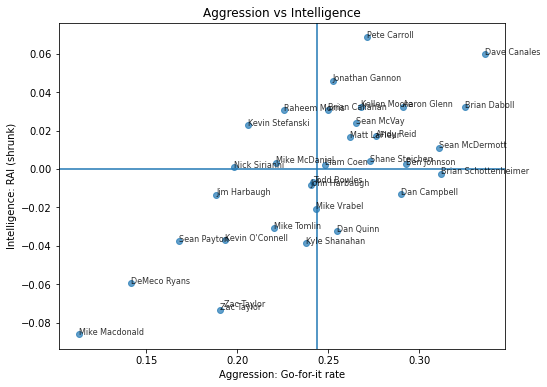

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.scatter(
    rai_plot["go_rate"],
    rai_plot["rai_shrunk"],
    alpha=0.7
)

plt.axvline(x0)
plt.axhline(y0)

# --- ADD LABELS
for coach, r in rai_plot.iterrows():
    plt.text(
        r["go_rate"],
        r["rai_shrunk"],
        str(coach),
        fontsize=8,
        alpha=0.8
    )

plt.xlabel("Aggression: Go-for-it rate")
plt.ylabel("Intelligence: RAI (shrunk)")
plt.title("Aggression vs Intelligence")

plt.text(
    r["go_rate"] + 0.002,
    r["rai_shrunk"] + 0.002,
    str(coach),
    fontsize=8,
    alpha=0.8
)

plt.show()

In [28]:
pbp_all, pbp_fourth_all = create_df_with_ewp(
    pbp,
    wp_model=wp_model,
    go_model=go_model,
    fg_model=fg_model,
    punt_model=punt_model,
    wp_features=wp_features,
    wp_base_features=wp_base_features,
    go_features=go_features,
    fg_features=fg_features,
    punt_features=punt_features
)

In [29]:
df = pbp_fourth_all.copy()

df["p_go_model"] = (
    p_go_from_margin(df["go_margin"], scale=best_scale)
    .clip(0.01, 0.99)
)

df["coach_go"] = (df["play_type_actual"] == "go").astype(int)

# decision residual: actual go (0/1) minus model p(go)
df["go_diff"] = df["coach_go"] - df["p_go_model"]

# league bias by season (important: the league's aggressiveness changes over time)
league_bias_by_season = df.groupby("season")["go_diff"].mean()

# RAI per team-season (mean residual, de-biased within season)
rai_team_season = (
    df.groupby(["season", "posteam"])["go_diff"].mean()
    .rename("rai_raw")
    .reset_index()
)

rai_team_season["league_bias"] = rai_team_season["season"].map(league_bias_by_season)
rai_team_season["rai"] = rai_team_season["rai_raw"] - rai_team_season["league_bias"]

In [30]:
past = (rai_team_season.query("season in [2022, 2023, 2024]")
        .groupby("posteam")["rai"]
        .mean()
        .rename("rai_22_24"))

future = (rai_team_season.query("season == 2025")
          .set_index("posteam")["rai"]
          .rename("rai_2025"))

stick_df = past.to_frame().join(future, how="inner")

In [31]:
x = stick_df["rai_22_24"].to_numpy()
y = stick_df["rai_2025"].to_numpy()

pearson_r, pearson_p = pearsonr(x, y)
spearman_r, spearman_p = spearmanr(x, y)

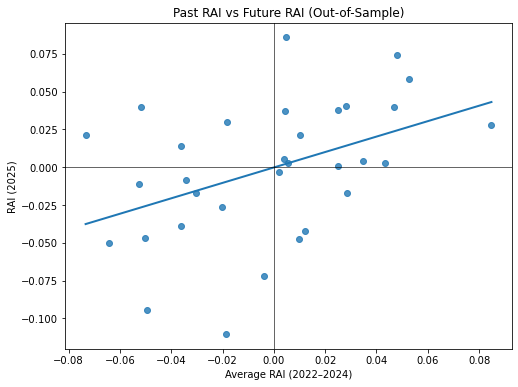

In [32]:
plt.figure(figsize=(8, 6))

# scatter
plt.scatter(x, y, alpha=0.8)

# regression line
coef = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = coef[0] * x_line + coef[1]
plt.plot(x_line, y_line, lw=2)

# reference lines
plt.axhline(0, color="black", lw=1, alpha=0.6)
plt.axvline(0, color="black", lw=1, alpha=0.6)

plt.xlabel("Average RAI (2022–2024)")
plt.ylabel("RAI (2025)")
plt.title("Past RAI vs Future RAI (Out-of-Sample)");

In [37]:
%cd Sports-Projects
!git add .
!git commit -m "Rename project folder to nfl-4th-down"
!git push

[WinError 2] The system cannot find the file specified: 'Sports-Projects'
C:\Users\david\Sports Analytics\4th Down Modeling\notebooks\Sports-Projects


[autoreload of project_code.functions failed: Traceback (most recent call last):
  File "C:\Users\david\anaconda3\lib\site-packages\nbformat\__init__.py", line 138, in read
    buf = fp.read()
AttributeError: 'WindowsPath' object has no attribute 'read'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\david\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\david\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\david\anaconda3\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\david\anaconda3\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
 

^C


In [40]:
%cd C:\Users\david
!dir


C:\Users\david
 Volume in drive C is OS
 Volume Serial Number is 426D-7755

 Directory of C:\Users\david

01/26/2026  06:24 PM    <DIR>          .
03/10/2025  02:49 AM    <DIR>          ..
05/26/2022  10:03 AM    <DIR>          .anaconda
05/22/2025  09:41 PM    <DIR>          .cache
11/30/2022  01:28 PM    <DIR>          .conda
11/30/2022  10:26 AM                42 .condarc
09/10/2021  09:13 AM    <DIR>          .continuum
01/26/2026  06:24 PM                56 .gitconfig
12/04/2021  05:58 PM    <DIR>          .i4j_jres
12/18/2025  12:26 PM    <DIR>          .ipynb_checkpoints
09/12/2021  07:27 PM    <DIR>          .ipython
02/27/2022  12:02 PM    <DIR>          .jupyter
09/14/2021  08:10 PM    <DIR>          .matplotlib
01/13/2024  03:06 PM    <DIR>          .pybaseball
10/29/2021  06:11 PM             1,454 .python_history
08/23/2021  04:28 PM    <DIR>          3D Objects
11/30/2022  01:16 PM    <DIR>          anaconda3
01/04/2022  12:25 PM    <DIR>          ansel
08/28/2021  10:49 

In [45]:
%cd 4th Down Modeling


C:\Users\david\Sports Analytics\4th Down Modeling


In [46]:
!dir

 Volume in drive C is OS
 Volume Serial Number is 426D-7755

 Directory of C:\Users\david\Sports Analytics\4th Down Modeling

01/14/2026  08:29 PM    <DIR>          .
12/18/2025  12:23 PM    <DIR>          ..
01/14/2026  08:29 PM    <DIR>          .ipynb_checkpoints
01/24/2026  10:49 AM    <DIR>          exports
01/26/2026  06:34 PM    <DIR>          notebooks
01/24/2026  10:46 AM    <DIR>          optuna
01/14/2026  09:08 PM    <DIR>          project_code
               0 File(s)              0 bytes
               7 Dir(s)  707,729,846,272 bytes free
